## Imports

In [20]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn



In [21]:
def _connect_mongo(host, port, db):
    """ A util for making a connection to mongo """
    try:
        client = pymongo.MongoClient(host, port)
        client.server_info()
    except pymongo.errors.ServerSelectionTimeoutError as err:
        print(err)
        print("Are you sure your database is on and this can reach it?") 
        raise ConnectionError
    return client[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)
    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))
    # Delete the _id
    if no_id:
        del df['_id']

    return df
train_df = read_mongo("NETWORK", "train")
test_df = read_mongo("NETWORK", "test")

## Data Cleaning and Understanding

In [22]:
train_df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [23]:
test_df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


Our dataset have the same amount of features. Of these, protocol type, service, flag and attack are categorical.

### Check for NaNs

In [24]:
print(train_df.isnull().values.any())

False


### Check how the rest of the data looks like

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

We have a mix of ints, floats and strings. No null values that need to be cleand, however.

### Check string answer 

In [26]:
print(len(train_df["service"].drop_duplicates().values))
print(len(test_df["service"].drop_duplicates().values))
print("------------------------------------------------")
train_df["service"].drop_duplicates()

70
64
------------------------------------------------


0          ftp_data
1             other
2           private
3              http
8        remote_job
            ...    
11124     http_8001
25718           aol
45071     http_2784
60799        tftp_u
81619       harvest
Name: service, Length: 70, dtype: object

In [27]:
print(len(train_df["protocol_type"].drop_duplicates().values))
print(len(test_df["protocol_type"].drop_duplicates().values))
print("------------------------------------------------")
train_df["protocol_type"].drop_duplicates()

3
3
------------------------------------------------


0      tcp
1      udp
17    icmp
Name: protocol_type, dtype: object

In [28]:
print(len(train_df["flag"].drop_duplicates().values))
print(len(test_df["flag"].drop_duplicates().values))
print("------------------------------------------------")
train_df["flag"].drop_duplicates()

11
11
------------------------------------------------


0           SF
2           S0
5          REJ
66        RSTR
146         SH
235       RSTO
694         S1
1023    RSTOS0
1857        S3
2286        S2
3768       OTH
Name: flag, dtype: object

In [29]:
print(len(train_df["attack"].drop_duplicates().values))
print(len(test_df["attack"].drop_duplicates().values))
print("------------------------------------------------")
train_df["attack"].drop_duplicates()

23
38
------------------------------------------------


0                 normal
2                neptune
13           warezclient
17               ipsweep
33             portsweep
46              teardrop
56                  nmap
62                 satan
138                smurf
211                  pod
366                 back
689         guess_passwd
2294           ftp_write
3005            multihop
3173             rootkit
5579     buffer_overflow
6086                imap
7040         warezmaster
10738                phf
16015               land
19448         loadmodule
21445                spy
66007               perl
Name: attack, dtype: object

In [30]:
print(test_df["num_outbound_cmds"].drop_duplicates())
print(train_df["num_outbound_cmds"].drop_duplicates())

0    0
Name: num_outbound_cmds, dtype: int64
0    0
Name: num_outbound_cmds, dtype: int64


Our labeled data does not look the same. This means we have to clean up our data. We would have to do some of this anyways, as models can't handle categorical data. We are going to do one hot encoding on our data. We are also going to drop num outbound cmds, as it's all 0:s.

In [31]:
train_df.drop("num_outbound_cmds", axis=1, inplace=True)
test_df.drop("num_outbound_cmds", axis=1, inplace=True)
assert test_df.isnull().values.any() == False
assert train_df.isnull().values.any() == False


In [32]:
def label_encoder_mapping(dataframe: pd.DataFrame, coloumn: str):
    labels = list(dataframe[coloumn].drop_duplicates().values)
    labels.sort()

    mapping = {}
    for index, label in enumerate(labels):
        mapping[label] = index+1

    return mapping

def transform_label(dataframe: pd.DataFrame, coloumns: list):
    for coloumn in coloumns:
        mapping = label_encoder_mapping(dataframe, coloumn)
        dataframe[coloumn] = dataframe[coloumn].map(mapping)

In [33]:
transform_label(train_df, ["flag", "protocol_type", "service"])
transform_label(test_df, ["flag", "protocol_type", "service"])

In [34]:
def transform_attack(dataframe):
    labels = list(dataframe["attack"].drop_duplicates().values)
    labels.sort()

    mapping = {}
    for index, label in enumerate(labels):
        if label == "normal":
            mapping[label] = 0
        else:
            mapping[label] = 1
    dataframe["attack"] = dataframe["attack"].map(mapping)



In [35]:

transform_attack(train_df)
transform_attack(test_df)

### Normalise values
Between 0 and 1, except for attack. To avoid vanishing / exploding gradients, normalize the data.

In [36]:
without_attack = train_df.drop(["attack"], axis=1, inplace=False)
normalized_train_df=(without_attack-without_attack.mean())/without_attack.std()
normalized_train_df["attack"] = train_df["attack"]
normalized_train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack
0,-0.110249,-0.124706,-0.686782,0.751108,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.782364,-0.280281,0.069972,-0.289102,-0.639529,-0.624868,-0.224532,-0.376386,0.216425,0
1,-0.110249,2.219303,0.781424,0.751108,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-1.161026,2.736841,2.367728,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,-1.965549,0
2,-0.110249,-0.124706,1.087301,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.938283,-0.174417,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,-0.219969,1
3,-0.110249,-0.124706,-0.442081,0.751108,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095075,...,1.066397,-0.439076,-0.383107,0.066252,-0.572081,-0.602430,-0.387633,-0.345083,0.652820,0
4,-0.110249,-0.124706,-0.442081,0.751108,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095075,...,1.066397,-0.439076,-0.480195,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,0.652820,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,-0.124706,1.087301,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.938283,-0.121485,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,0.216425,1
125969,-0.107177,2.219303,1.087301,0.751108,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095075,...,0.977300,-0.386144,-0.447832,-0.289102,-0.639529,-0.624868,-0.387633,-0.376386,0.652820,0
125970,-0.110249,-0.124706,1.393177,0.751108,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095075,...,-0.893735,-0.121485,-0.480195,-0.289102,0.979234,-0.624868,-0.355013,-0.376386,-0.656364,0
125971,-0.110249,-0.124706,-0.075030,-0.736232,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095075,...,-1.094203,-0.174417,-0.480195,-0.289102,1.608753,1.618949,-0.387633,-0.376386,0.216425,1


In [37]:
without_attack = test_df.drop(["attack"], axis=1, inplace=False)
normalized_test_df=(without_attack-without_attack.mean())/without_attack.std()
normalized_test_df["attack"] = test_df["attack"]
normalized_test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack
0,-0.155531,-0.176299,0.933943,-1.829914,-0.021988,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,-1.305341,-0.138367,-0.431847,-0.229975,-0.358110,-0.352742,1.979747,1.929073,0.698310,1
1,-0.155531,-0.176299,0.933943,-1.829914,-0.021988,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,-1.397150,-0.138367,-0.431847,-0.229975,-0.358110,-0.352742,1.979747,1.929073,0.698310,1
2,-0.154109,-0.176299,-0.882235,0.662241,0.005473,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,0.002934,-0.228980,1.559871,0.004234,-0.358110,-0.352742,-0.602706,-0.565471,0.698310,0
3,-0.155531,-2.694991,-1.301353,0.662241,-0.021945,-0.096894,-0.017623,-0.059103,-0.019459,-0.113519,...,0.898070,-0.410208,2.833265,3.048948,-0.358110,-0.352742,-0.602706,-0.565471,-0.706724,1
4,-0.154820,-0.176299,1.632473,-1.518394,-0.021988,-0.096187,-0.017623,-0.059103,-0.019459,-0.113519,...,-0.685632,0.360010,-0.333893,0.004234,-0.358110,-0.352742,1.540730,1.205656,-1.643413,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,-0.155531,-0.176299,1.213355,0.662241,-0.020308,-0.081201,-0.017623,-0.059103,-0.019459,-0.113519,...,0.255408,-0.138367,-0.399195,-0.112871,-0.321498,-0.352742,-0.602706,-0.565471,0.698310,0
22540,-0.155531,-0.176299,-0.672676,0.662241,-0.021317,-0.052689,-0.017623,-0.059103,-0.019459,-0.113519,...,0.898070,-0.410208,-0.399195,-0.112871,-0.321498,-0.352742,-0.602706,-0.565471,0.698310,0
22541,-0.155531,-0.176299,-0.672676,0.662241,0.093371,0.294919,-0.017623,-0.059103,-0.019459,2.040660,...,0.898070,-0.410208,-0.431847,-0.229975,-0.358110,-0.352742,-0.421934,-0.390852,-0.706724,1
22542,-0.155531,2.342392,-1.441059,0.662241,-0.021899,-0.094914,-0.017623,-0.059103,-0.019459,-0.113519,...,0.875118,-0.364901,-0.431847,-0.229975,-0.358110,-0.352742,-0.602706,-0.565471,0.698310,0


## Data distribution
Should go back and visit this area, should have a before and after the normalization / cleaning.

In [38]:
distribution = test_df["attack"].value_counts().reset_index()
distribution.columns = ["attack", "count"]
print(distribution)

   attack  count
0       1  12833
1       0   9711


/tmp/ipykernel_819/3358764466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=distribution, y="attack", x="count", palette='viridis')


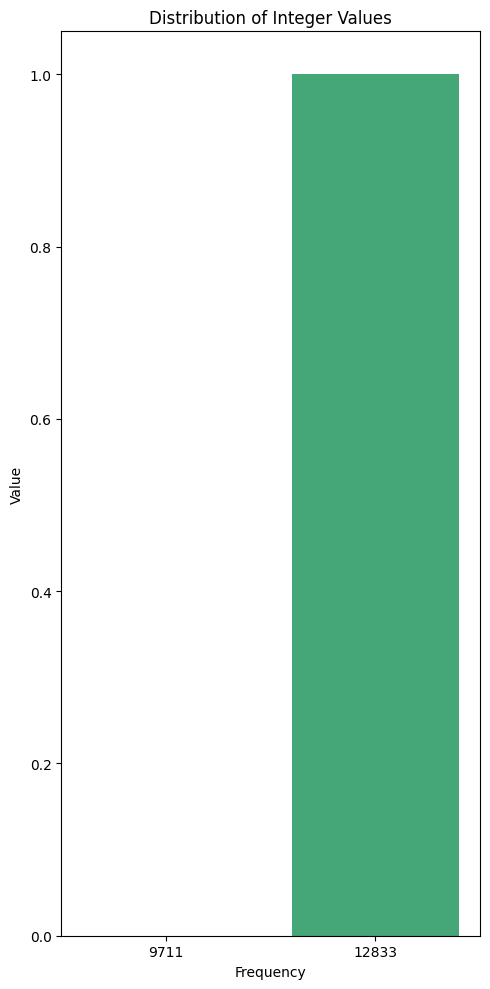

In [39]:
fig = plt.figure(figsize=(5,10))
sns.barplot(data=distribution, y="attack", x="count", palette='viridis')

plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Distribution of Integer Values')
plt.tight_layout()
plt.show()

/tmp/ipykernel_819/1274555815.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=distribution_filtered, y='attack', x='count', palette='magma')


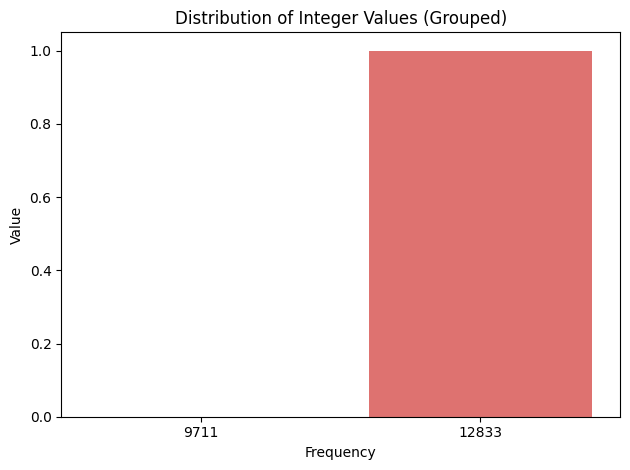

In [40]:
threshold = 500
high_freq = distribution[distribution['count'] >= threshold]
low_freq = distribution[distribution['count'] < threshold]

other_count = low_freq['count'].sum()
if other_count > 0:
    other_row = pd.DataFrame([{'attack': 'Other', 'count': other_count}])
    distribution_filtered = pd.concat([high_freq, other_row], ignore_index=True)
else:
    distribution_filtered = high_freq

sns.barplot(data=distribution_filtered, y='attack', x='count', palette='magma')

plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Distribution of Integer Values (Grouped)')
plt.tight_layout()
plt.show()

## Model

In [41]:
# https://arxiv.org/pdf/1607.00148.pdf
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device)
        self.decoder = Decoder(num_layers, nb_feature, hidden_size, dropout, device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float)
        encoder_output = self.encoder(input_seq)  

        input_decoder = encoder_output[:, -1, :].unsqueeze(1)  # shape: [batch, 1, hidden_size]
        
        decoder_hidden = (
            torch.randn((self.decoder.num_layers, input_seq.size(0), self.decoder.hidden_size)).to(self.device),
            torch.randn((self.decoder.num_layers, input_seq.size(0), self.decoder.hidden_size)).to(self.device)
        )
        
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, decoder_hidden = self.decoder(input_decoder, decoder_hidden)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        
        return output

class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Encoder, self).__init__()
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.hidden_cell = None

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )

    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        output, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return output 

class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Decoder, self).__init__()
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell

# TRAIN

In [42]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, device = None, transform=None, target_transform=None):
        self.df_labels = dataframe["attack"]
        self.df = dataframe.drop(["attack"], axis=1, inplace=False)
        self.transform = transform
        self.target_transform = target_transform
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]
        label = self.df_labels.iloc[idx]
        tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)
        tensor_label = torch.tensor(label, device=self.device, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor_data, tensor_label

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1E-3
lstm = LSTMAutoEncoder(nb_feature=41, num_layers=1, hidden_size=41, device=device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)

batch_size = 32
training_data = CustomDataset(normalized_train_df[normalized_train_df["attack"]==0])
test_data = CustomDataset(normalized_test_df[normalized_test_df["attack"]==0])
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)



In [44]:

def train(device, lstm, loss_fn, optimizer, batch_size, loader, verbose=True):
    lstm = lstm.train()
    train_loss = 0
    with torch.autograd.set_detect_anomaly(True):
        for batch, (X, y) in enumerate(loader):
            X, _ = X.to(device), y.to(device)
        # Compute prediction error
            pred = lstm(X)
            loss = loss_fn(pred, X)

        # Backpropagation

            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            if (batch % 100 == 0) and verbose:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    avg_loss = train_loss / len(loader)
    return avg_loss
train(device, lstm, loss_fn, optimizer, batch_size, train_dataloader, verbose=True)

/tmp/ipykernel_819/2807056169.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)


loss: 0.486972  [   32/   32]
loss: 0.422305  [ 3232/   32]
loss: 0.313376  [ 6432/   32]
loss: 0.130990  [ 9632/   32]
loss: 1.689961  [12832/   32]
loss: 0.093189  [16032/   32]
loss: 0.074848  [19232/   32]
loss: 0.027962  [22432/   32]
loss: 0.060114  [25632/   32]
loss: 0.099237  [28832/   32]
loss: 0.089847  [32032/   32]
loss: 0.113564  [35232/   32]
loss: 0.067520  [38432/   32]
loss: 0.024593  [41632/   32]
loss: 0.054632  [44832/   32]
loss: 9.539010  [48032/   32]
loss: 0.052953  [51232/   32]
loss: 0.024374  [54432/   32]
loss: 0.014534  [57632/   32]
loss: 0.046358  [60832/   32]
loss: 0.035612  [64032/   32]
loss: 0.030023  [67232/   32]


0.5008988968320103

In [45]:
def test(device, lstm, loss_fn, batch_size, loader, verbose = True):
    lstm = lstm.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(loader):
            X, _ = X.to(device), y.to(device)

            pred = lstm(X)
            loss = loss_fn(pred, X)

            eval_loss += loss.item()
            if (batch % 100 == 0) and verbose:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{batch_size:>5d}]")
    avg_loss = eval_loss / len(loader)
    return avg_loss


test(device, lstm, loss_fn, batch_size, test_dataloader)

loss: 0.615558  [   32/   32]


/tmp/ipykernel_819/2807056169.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)


loss: 0.027356  [ 3232/   32]
loss: 0.058841  [ 6432/   32]
loss: 0.041364  [ 9632/   32]


0.41593483451288193

In [46]:
train_loss = [0]*10
for i in range(0, 10):
    train_loss[i] = train(device, lstm, loss_fn, optimizer, batch_size, train_dataloader, verbose=False)
test_loss = test(device, lstm, loss_fn, batch_size, test_dataloader, verbose=False)
print(train_loss)
print(test_loss)

/tmp/ipykernel_819/2807056169.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tensor_data = torch.tensor(image, device=self.device, dtype=torch.float32).unsqueeze(0)


[0.34498689520059955, 0.28993332279257633, 0.2573138676716497, 0.23547766998989814, 0.22119701666759675, 0.21110768223854973, 0.2038809654113755, 0.19895369529579224, 0.19595713698849382, 0.18935337173874156]
0.3578717442823721
